In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import datetime
import seaborn as sns
from sklearn.preprocessing import StandardScaler

import os
for dirname, _, filenames in os.walk('../data/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

../data/ozon_4_.ipynb
../data/sample_submit.csv
../data/smoto_submission_ensemble.csv
../data/smoto_submission_lightBGM.csv
../data/smoto_submission_Logistic.csv
../data/submission_ensemble.csv
../data/submission_lightBGM.csv
../data/submission_lightBGM2.csv
../data/submission_lightBGM2_2.csv
../data/submission_lightBGM3.csv
../data/submission_Logistic.csv
../data/submission_Logistic2.csv
../data/submission_Logistic3.csv
../data/sumoto_submission_Logistic2.csv
../data/sumoto_submission_Logistic3.csv
../data/sumoto_submission_Logistic3_2.csv
../data/test.tsv
../data/train.tsv
../data/.ipynb_checkpoints\ozon_4_-checkpoint.ipynb
../data/.ipynb_checkpoints\sample_submit-checkpoint.csv
../data/.ipynb_checkpoints\submission_ensemble-checkpoint.csv
../data/.ipynb_checkpoints\submission_lightBGM-checkpoint.csv
../data/.ipynb_checkpoints\submission_lightBGM3-checkpoint.csv
../data/.ipynb_checkpoints\submission_Logistic-checkpoint.csv
../data/.ipynb_checkpoints\submission_Logistic2-checkpoint.cs

In [2]:
train_df = pd.read_table('../data/train.tsv', index_col='Date', parse_dates=True)
test_df = pd.read_table('../data/test.tsv', index_col='Date', parse_dates=True)
sample_sub = pd.read_csv('../data/sample_submit.csv')

# set type label
train_df['type'] = 'train'
test_df['type'] = 'test'

# all data
all_df = pd.concat([train_df, test_df], axis=0)

# OZONEが高い日の数
train_df[train_df["OZONE"]==1.0].sum


<bound method NDFrame._add_numeric_operations.<locals>.sum of               id  WSR0  WSR1  WSR2  WSR3  WSR4  WSR5  WSR6  WSR7  WSR8  ...  \
Date                                                                    ...   
1998-04-05    94   0.4   0.5   2.1   2.2   2.5   2.4   2.1   2.9   3.6  ...   
1998-04-11   100   0.0   0.6   0.4   0.3   0.1   0.3   0.2   1.4   2.6  ...   
1998-04-20   109   1.8   0.3   0.1   0.1   0.1   0.2   0.2   0.7   0.9  ...   
1998-04-23   112   0.5   0.1   0.1   0.1   0.1   0.2   0.3   0.8   1.2  ...   
1998-04-25   114   3.1   2.4   2.4   3.0   3.4   3.4   3.9   4.5   5.5  ...   
...          ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
2001-05-23  1225   0.8   0.3   0.2   0.4   0.3   1.4   0.9   1.5   1.9  ...   
2001-06-15  1248   2.2   1.7   0.8   3.8   4.0   4.1   2.0   1.9   1.8  ...   
2001-06-16  1249   0.4   0.4   0.1   0.1   0.0   0.4   0.5   0.6   1.3  ...   
2001-06-18  1251   0.4   0.7   0.5   0.6   0.8   1.0   1.6   1.5   2.

## 学習する特徴量を作成


In [3]:
import re
from imblearn.over_sampling import SMOTE

def eda(all_df):
    # データの追加,気温・風速の標準偏差
    #1時間ごとの気温・風速を取得
    T_data = all_df[['T0', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9', 'T10', 'T11', 'T12', 'T13', 'T14', 'T15', 'T16', 'T17', 'T18', 'T19', 'T20', 'T21', 'T22', 'T23']]
    WSR_data = all_df[['WSR0', 'WSR1', 'WSR2', 'WSR3', 'WSR4', 'WSR5', 'WSR6', 'WSR7', 'WSR8', 'WSR9', 'WSR10', 'WSR11', 'WSR12', 'WSR13', 'WSR14', 'WSR15', 'WSR16', 'WSR17', 'WSR18', 'WSR19', 'WSR20', 'WSR21', 'WSR22', 'WSR23']]
    # 行ごとの標準偏差を追加
    # all_df['T_SD'] = T_data.std(axis=1)
    # all_df['WSR_SD'] = WSR_data.std(axis=1)
    # 行ごとの最高気温/風速を追加
    all_df['T_MAX'] = T_data.max(axis=1)
    all_df['WSR_MAX'] = WSR_data.std(axis=1)
    
    # ○○ヘクトパスカル面の風速を統一
    # all_df['UV50'] = np.sqrt(all_df['U85']**2+ all_df['V85']**2)
    # all_df['UV70'] = np.sqrt(all_df['U70']**2 + all_df['V70']**2)
    # all_df['UV50'] = np.sqrt(all_df['U50']**2 + all_df['V50']**2)
    
    # 時系列(月)を特徴量に追加
    # all_df['month'] =  all_df.index.month

    # データの削除, T0~T23
    all_df = all_df.drop(columns=['T0', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9', 'T10', 'T11', 'T12', 'T13', 'T14', 'T15', 'T16', 'T17', 'T18', 'T19', 'T20', 'T21', 'T22', 'T23'])
    # データの削除, WSR0~WSR23
    all_df = all_df.drop(columns=['WSR0', 'WSR1', 'WSR2', 'WSR3', 'WSR4', 'WSR5', 'WSR6', 'WSR7', 'WSR8', 'WSR9', 'WSR10', 'WSR11', 'WSR12', 'WSR13', 'WSR14', 'WSR15', 'WSR16', 'WSR17', 'WSR18', 'WSR19', 'WSR20', 'WSR21', 'WSR22', 'WSR23'])
    
    # データの削除, SLP_
    all_df = all_df.drop(columns=['SLP_'])
    
    # ○○ヘクトパスカル面の風速の各方向を削除, U85,V85,U70,...
    # all_df = all_df.drop(columns=['U85','V85','U70','V70','U50','V50'])
    
    return all_df

def time_encode(df, col):
    # この方法だと場合によって最大値が変化するデータでは正確な値は出ない
    # 例：月の日数が30日や31日の場合がある
    df[col + '_cos'] = np.cos(2 * np.pi * df[col] / df[col].max())
    df[col + '_sin'] = np.sin(2 * np.pi * df[col] / df[col].max())
    return df



# 特徴量の削除/追加
all_df = eda(all_df)

# trainとtestに分けなおす
train_df = all_df[all_df['type'] == 'train']
test_df = all_df[all_df['type'] == 'test']
# train正解ラベル
y = train_df['OZONE']

# 学習に不要な特徴量を削除
train_df = train_df.drop(columns=['id', 'OZONE', 'type'])
test_df = test_df.drop(columns=['id', 'OZONE', 'type'])

# 欠損値を平均値で補完
train_df = train_df.fillna(train_df.mean())
test_df = test_df.fillna(test_df.mean())
# 欠損値を上のカラムで補完
# train_df = train_df.ffill()
# test_df = test_df.ffill()

# データ標準化(rightGBMのときはいらない)
scaler = StandardScaler()
train_df = pd.DataFrame(scaler.fit_transform(train_df), index = train_df.index, columns = train_df.columns)
test_df = pd.DataFrame(scaler.transform(test_df), index = test_df.index, columns = test_df.columns)

# 時系列(月)を特徴量に追加
train_df['month'] =  train_df.index.month
test_df['month'] =  test_df.index.month
"""
train_df = time_encode(train_df, 'month')
test_df = time_encode(test_df, 'month')
train_df = train_df.drop(columns=['month'])
test_df = test_df.drop(columns=['month'])
"""
# オーバーサンプリング
# SMOTEの初期化と適用
smote = SMOTE(random_state=42)
train_df, y = smote.fit_resample(train_df, y)

print(f'train_df : \n{train_df}\n')
print(f'y : \n{y}\n')

train_df : 
        WSR_PK    WSR_AV      T_PK      T_AV           T85          RH85  \
0     1.015406  0.727247 -0.935098 -1.211422 -1.400513e+00 -1.821665e+00   
1     1.015406  1.049596 -0.482037 -0.456681 -9.295647e-01 -1.250812e+00   
2     1.102038  1.157046 -0.509495 -0.328518 -9.295647e-01  1.321889e-02   
3     0.322351  0.834697 -0.866453 -0.328518 -7.452807e-01  1.358801e+00   
4    -0.543968 -0.132352  0.012212  0.013251  3.637269e-16 -1.810783e-15   
...        ...       ...       ...       ...           ...           ...   
2307 -0.753449 -0.901346  1.437890  1.378840  1.440302e+00 -8.156491e-01   
2308 -0.336653 -0.460422  0.046710 -0.108585  3.316399e-02 -1.488510e+00   
2309 -0.543968 -0.908089  1.366817  1.191265  1.431000e+00 -1.760681e-01   
2310 -0.613926 -0.785294  0.796935  0.644256 -9.037970e-02 -1.391275e-01   
2311  0.208175 -0.357300  0.962090  0.726602  1.518748e+00 -1.137638e+00   

               U85           V85      HT85           T70  ...           U50

## 検証データ作成

In [4]:
from sklearn.model_selection import train_test_split
# 訓練データの一部を分割し検証データを作成
# 注意 :   
# shuffleをTrueにするとランダムに分割されます。
# この時、random_stateを定義していないとモデルの再現性が取れなくなるので、設定するよう心がけてください。
# test_size=0.2とすることで訓練データの２割を検証データにしている

X_train ,X_val ,y_train ,y_val = train_test_split(
    train_df, y, 
    test_size=0.3, shuffle=True,random_state=0
    )

## モデルの作成と評価
今回はロジェスティック回帰

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score,accuracy_score

# モデルを定義し学習
model = LogisticRegression(max_iter=3000) 
model.fit(X_train, y_train)
print(model.score(X_train, y_train))

# 訓練データに対しての予測を行い、正答率を算出
y_pred = model.predict(X_val)
print(balanced_accuracy_score(y_val, y_pred))

0.8733003708281829
0.8739614489863742


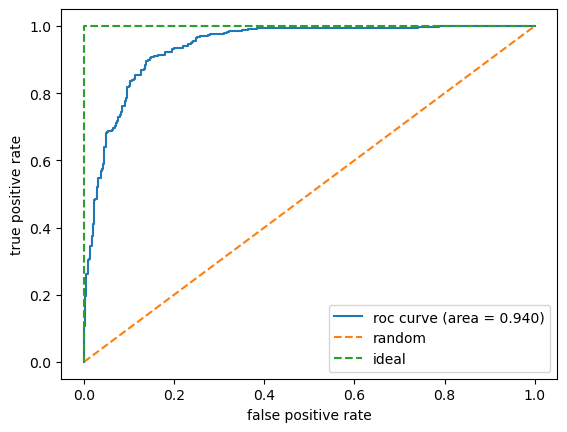

In [6]:
from sklearn.metrics import roc_curve, auc

y_score = model.predict_proba(X_val)[:, 1] # 検証データがクラス1に属する確率
fpr, tpr, thresholds = roc_curve(y_true=y_val, y_score=y_score)

plt.plot(fpr, tpr, label='roc curve (area = %0.3f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], linestyle='--', label='random')
plt.plot([0, 0, 1], [0, 1, 1], linestyle='--', label='ideal')
plt.legend()
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.show()

In [7]:
# テストデータを予測
test_pred = model.predict(test_df)

# 行数で繰り返し予測値を代入
for index, row in sample_sub.iterrows():
    sample_sub.iloc[index,1] = np.where(test_pred[index]>=0.5, 1, 0)

# 結果を保存
# sample_sub.to_csv("../data/submission_Logistic3.csv", index=False)
# sample_sub.to_csv("../data/sumoto_submission_Logistic3.csv", index=False)
sample_sub.to_csv("../data/sumoto_submission_Logistic3_3.csv", index=False)

In [8]:
test_pred.sum()

203.0